> Created on Mon May  8 08:34:55 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.5-B 推理学习：概率图


## 3.5.1 基于概率模型的分类器

对于多维随机变量，且之间相互独立，如果可以由已知样本（特征）和对应的事件（分类）得每一随机变量的概率密度函数（边缘密度函数）或联合分布律，并以观测到的随机变量为条件计算后验分布，则可以用这个后验分布预测新样本的分类。例如对鸢尾花（iris）数据集，分布用[Skearn（scikit-learn）](https://scikit-learn.org/stable/modules/naive_bayes.html)的`GaussianNB`方法，和自定义高斯朴素贝叶斯分类器阐述连续型随机变量概率模型的构建；并将鸢尾花数据集连续型随机变量转化为离散型随机变量，构建用于离散型随机变量分类的概率模型。

### 3.5.1.1 连续型随机变量分类器

`Sklearn`的`Naive Bayes`（朴素贝叶斯）目前集成了"Gaussian Naive Bayes"、"Multinomial Naive Bayes"、"Complement Naive Bayes"、"Bernoulli Naive Bayes"和"Categorical Naive Bayes"等算法。下面应用`GaussianNB`试验。

#### 1）`scikit-learn`的`GaussianNB`




In [29]:
import daft
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import preprocessing

import numpy as np
from scipy.special import logsumexp
import pandas as pd
from scipy.stats import norm

from sympy.stats import P, E, variance, Die, Normal,density
from sympy import simplify,Symbol,lambdify

读取鸢尾花数据集，打印查看数据集情况。总共有4个特征列（'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'），每一特征对应一个随机变量，为多维随机变量。数据含3种分类结果（'setosa' 'versicolor' 'virginica'），分别对应标签0、1和2。

In [41]:
iris=load_iris()
print(f'---feature names:\n{iris.feature_names};\n---target names{iris.target_names}\n---data[:3]:\n{iris.data[:3]};\n---target:\n{iris.target}')

---feature names:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'];
---target names['setosa' 'versicolor' 'virginica']
---data[:3]:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]];
---target:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


直接使用集成的`GaussianNB`算法估计概率模型，并用该模型测试数据集75个观测样本，正确率为$(75-4)/75=0.946$。

In [44]:
X, y=load_iris(return_X_y=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.5, random_state=0)
gnb=GaussianNB()
y_pred=gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 75 points : 4


使用集成封装后的方法不能够直接观察计算的过程，因此提取`GaussianNB`方法的主要代码行，整理如下。其中`update_mean_variance`方法用于计算用于高斯分布的样本特征均值和方差。`joint_log_likelihood`方法用于构建联合对数概率估计（joint log probability estimates）。

> `GaussianNB`方法位于`Sklearn`包的`naive_bayes.py`模块下。

In [58]:
def update_mean_variance(n_past, mu, var, X):
    if X.shape[0] == 0:
        return mu, var
    
    n_new=X.shape[0]
    new_var=np.var(X, axis=0)
    new_mu=np.mean(X, axis=0)
    
    if n_past == 0:
        return new_mu, new_var    
    
    n_total=float(n_past + n_new)
    total_mu=(n_new * new_mu + n_past * mu) / n_total
    old_ssd=n_past * var
    new_ssd=n_new * new_var
    total_ssd=old_ssd + new_ssd + (n_new * n_past / n_total) * (mu - new_mu) ** 2
    total_var=total_ssd / n_total
    
    return total_mu, total_var

def joint_log_likelihood(X,classes_,class_prior_,var_,theta_):
    joint_log_likelihood = []
    for i in range(np.size(classes_)):
        jointi = np.log(class_prior_[i])
        n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * var_[i, :]))
        n_ij -= 0.5 * np.sum(((X - theta_[i, :]) ** 2) / (var_[i, :]), 1)
        joint_log_likelihood.append(jointi + n_ij)
    
    joint_log_likelihood = np.array(joint_log_likelihood).T
    return joint_log_likelihood

In [67]:
X=X_train
y=y_train

_, n_features=X.shape
labelbin=preprocessing.LabelBinarizer()
Y=labelbin.fit_transform(y)
classes_=labelbin.classes_
n_classes=Y.shape[1]
class_log_prior_=np.full(n_classes, -np.log(n_classes))

unique_y=np.unique(y)

class_count_=np.zeros(n_classes, dtype=np.float64)
theta_=np.zeros((n_classes, n_features))
var_ = np.zeros((n_classes, n_features))

var_smoothing=1e-9
epsilon_=var_smoothing * np.var(X, axis=0).max()

for y_i in unique_y:
    i=classes_.searchsorted(y_i)
    X_i=X[y == y_i, :]
    N_i=X_i.shape[0]
    
    new_theta, new_sigma=update_mean_variance(class_count_[i],theta_[i, :],var_[i, :],X_i)
    theta_[i, :]=new_theta
    var_[i, :]=new_sigma
    class_count_[i] += N_i
    
var_[:, :] += epsilon_

class_prior_=class_count_ / class_count_.sum()
jll=joint_log_likelihood(X,classes_,class_prior_,var_,theta_)
print(jll[:3])
predicted_y=classes_[np.argmax(jll, axis=1)]
print(predicted_y)

[[   0.8762294   -32.51665712  -73.95573104]
 [-556.7018906    -5.71630183   -3.68412747]
 [-119.04667384   -5.66092211  -28.96539079]]
[0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0
 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 2 0 1 2 2 0 1 1 2 1 0 0 0 2 1 2
 0]


#### 2） 自定义高斯朴素贝叶斯分类器

朴素（简单）贝叶斯分类器（Naive Bayes Classifier，NBC）是基于给定类变量（分类$y$）的所有属性（对应特征的随机变量$(X_1,X_2,\cdots,X_n)$）都是独立的假设，有$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)}{P(x_1, \dots, x_n)}$，及$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)$，可以推导出$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)} {P(x_1, \dots, x_n)}$。因为$(P(x_1, \dots, x_n)$作为常数输入，所以分类规则为：$\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}$。可以使用最大后验概率（ Maximum A Posteriori，MAP）估计$P(y)$和$P(x_i \mid y)$。不同类的朴素贝叶斯分类器的差异主要在于对$P(x_i \mid y)$的定义<sup>[Naive Bayes, <https://scikit-learn.org/stable/modules/naive_bayes.html>.]</sup>。

虽然朴素贝叶斯的假设过于简化，但在现实世界的许多情况下运行良好；且可以用少量的训练数据来估计必要的参数。
    
定义高斯朴素贝叶斯分类器`Gaussian_naive_bayes_classifier`类。为了简化代码书写，更清晰的表述分类器的算法机制，对随机变量概率密度函数（使用高斯分布）的定义，使用了`SymPy`库直接书写；并使用`pandas`的`DataFrame`数据结构，尽量一一对应不同变量之间的对应关系，便于理解。

In [68]:
class Gaussian_naive_bayes_classifier:   
    '''
    高斯朴素贝叶斯分类器。使用到SymPy库计算
    '''

    def fit(self,X, y,feature_names):     
        '''
        由已知样本数据，构建各随机变量边缘概率密集函数，预测新样本类别函数和计算精度

        Parameters
        ----------
        X : array
            样本特征.
        y : array
            分类标签.
        feature_names : List[string]
            特征名称列表.

        Returns
        -------
        Class
            类的属性值.

        '''
        self.feature_names=feature_names
        
        df=pd.DataFrame(X,columns=feature_names)
        df['target']=y       
        mean_std=df.groupby(by=['target']).agg(["mean","std"])     
        self.norms=mean_std.apply(self.norm_func,args=(feature_names,), axis=1, result_type='expand')  
        joint_prob=self.job_prob_func(df)     
        self.mislabeled(joint_prob,X,y)
        
        return self
        
    def norm_func(self,row,feature_names):
        '''
        由已知样本数据计算的均值和标注差，构建各随机变量边缘概率密集函数（假设服从正态分布）。用于DataFrame.apply()方法

        Parameters
        ----------
        row : Series
            由已知样本数据计算的均值和标注差.
        feature_names : List[string]
            特征名称列表.

        Returns
        -------
        Series
            随机变量的边缘密度函数.

        '''
        norms_lst=[]
        for feature_name in feature_names:
            dens=density(Normal('X',row[feature_name]['mean'],row[feature_name]['std']))
            norms_lst.append(dens)

        return pd.Series(norms_lst,index=feature_names)        
        
    def prob_prod(self,row,norms_df):
        '''
        假设随机变量相互独立，由边缘密度函数计算给定特征值的概率。用于DataFrame.apply()方法

        Parameters
        ----------
        row : Series
            特征值.
        norms_df : DataFrame
            随机变量的边缘密度函数.

        Returns
        -------
        Series
            概率值.

        '''
        p_prods=[]
        idxes=[]
        for idx,norms_target in norms_df.iterrows():
            norms_target_lst=norms_target.values    
            p_prod=np.prod([norm(x).evalf() for norm,x in zip(norms_target_lst,row)])
            p_prods.append(p_prod)
            idxes.append(idx)
        return pd.Series(p_prods,index=idxes)   
    
    def job_prob_func(self,df):
        '''
        联合概率

        Parameters
        ----------
        df : DataFrame
            特征值.

        Returns
        -------
        joint_prob : DataFrame
            各个样本对应分类的概率.

        '''
        joint_prob=df.apply(self.prob_prod,args=(self.norms,),axis=1)
        joint_prob['p_max_target']=joint_prob.apply(lambda row:row.astype(float).idxmax(),axis=1)        
        
        return joint_prob
    
    def predict(self,X):
        '''
        根据构建的后验分布（预测模型）预测新样本数据的分类

        Parameters
        ----------
        X : array
            样本特征值.

        Returns
        -------
        joint_prob_predicted : DataFrame
            预测分类结果和概率.

        '''
        df=pd.DataFrame(X,columns=self.feature_names)
        joint_prob_predicted=self.job_prob_func(df)      
        
        return joint_prob_predicted
    
    def mislabeled(self,joint_prob,X,y):
        '''
        计算分类精度

        Parameters
        ----------
        joint_prob : DataFrame
            预测分类结果数据.
        X : array
            样本特征值.
        y : array
            样本分类值.

        Returns
        -------
        None.

        '''
        joint_prob['target']=y
        joint_prob['correct']=joint_prob.apply(lambda row:row.p_max_target==row.target,axis=1) 
        print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0],X.shape[0]-joint_prob['correct'].sum()))          
        

iris_classification=Gaussian_naive_bayes_classifier()
iris_classification.fit(X_train,y_train,['sepal_length','sepal_width','petal_length','petal_width'])
test_predicted=iris_classification.predict(X_test)
iris_classification.mislabeled(test_predicted,X_test,y_test)
test_predicted.head()

Number of mislabeled points out of a total 75 points : 2
Number of mislabeled points out of a total 75 points : 5


,0,1,2,p_max_target,target,correct
0,3.99493353970977e-289,1.05404275436796e-6,0.0449990901096858,2,2,True
1,4.56660272749500e-102,0.119858087756389,4.33560630854775e-10,1,1,True
2,0.312501002072666,6.15924326913282e-18,1.25771736578052e-32,0,0,True
3,1.89560807069258e-374,6.83814201533865e-7,0.136003790622231,2,2,True
4,14.7330640043679,1.04705609546837e-13,1.51596858717064e-30,0,0,True


打印随机变量的边缘密度函数，即$P(x_i \mid y)$，由`SymPy`方式表示。

In [35]:
iris_classification.norms

,sepal_length,sepal_width,petal_length,petal_width
target,,,,
0,"NormalDistribution(4.97586206896552, 0.3269503...","NormalDistribution(3.35862068965517, 0.3698621...","NormalDistribution(1.44827586206897, 0.1298919...","NormalDistribution(0.23448275862069, 0.0936401..."
1,"NormalDistribution(5.935, 0.5193872908483)","NormalDistribution(2.71, 0.295403381657585)","NormalDistribution(4.185, 0.518372960633355)","NormalDistribution(1.3, 0.220047841688072)"
2,"NormalDistribution(6.77692307692308, 0.6358035...","NormalDistribution(3.09230769230769, 0.3248668...","NormalDistribution(5.73461538461538, 0.5705732...","NormalDistribution(2.10769230769231, 0.2225723..."


### 3.5.1.2 离散型随机变量分类器

仍然使用鸢尾花数据集，但是需要将特征值转化为整数形式，构成离散型随机变量的输入。通过`self.joint_prob=Xy.groupby(by=Xy.columns.tolist()).size() / len(Xy)`代码计算多维随机变量的联合分布律，结果如`iris_classification_discrete.joint_prob`所示，并通过已知分类计算后验概率，则可以通过后验概率推断新样本对应的分类值，即将离散型样本特征值对应到联合分布律，结果可能有对应不同分类结果的多个概率值，其中最大概率对应的分类即为估计的分类结果。

从测试数据集的预测结果来看，正确率为$(30-2)/30=0.933$。

In [93]:
mini_iris = np.round(iris.data[:, :]).astype(int)
data = pd.DataFrame(mini_iris, columns=['sepal_length','sepal_width','petal_length','petal_width'])
data['type'] = iris.target

#Shuffle data
data = data.iloc[np.random.permutation(len(data))]
X_train, X_test=data[:120], data[120:]
X_train

,sepal_length,sepal_width,petal_length,petal_width,type
86,7,3,5,2,1
78,6,3,4,2,1
61,6,3,4,2,1
89,6,2,4,1,1
138,6,3,5,2,2
...,...,...,...,...,...
90,6,3,4,1,1
38,4,3,1,0,0
121,6,3,5,2,2
54,6,3,5,2,1


In [94]:
class Discrete_probabilisitic_model_classifier:
    '''
    定义多维离散型随机变量分类器概率模型
    '''    
    def fit(self,Xy):
        self.joint_prob=Xy.groupby(by=Xy.columns.tolist()).size() / len(Xy)
        
        return self
    
    def predict(self,X):
        predicted_values = []
        for idx,row in X.iterrows():   
            try:
                for i,v in enumerate(row):
                    if i==0:
                        multiIndex_val=self.joint_prob[v]
                    else:
                        multiIndex_val=multiIndex_val[v]
                        
                predicted_values.append(multiIndex_val.idxmax())
            except:
                predicted_values.append(-1)
                
        return predicted_values
    
    def mislabeled(self,y_,y):
        y_y=zip(y_,y)
        mislabeled_num=sum([i[0]!=i[1] for i in y_y])
        print("Number of mislabeled points out of a total %d points : %d" % (len(y_),mislabeled_num))   

iris_classification_discrete=Discrete_probabilisitic_model_classifier()
iris_classification_discrete.fit(X_train)
predicted_values=iris_classification_discrete.predict(X_test[['sepal_length','sepal_width','petal_length','petal_width']])
iris_classification_discrete.mislabeled(predicted_values,X_test.type.to_numpy())

Number of mislabeled points out of a total 30 points : 2


In [95]:
iris_classification_discrete.joint_prob

sepal_length  sepal_width  petal_length  petal_width  type
4             2            1             0            0       0.008333
              3            1             0            0       0.025000
5             2            3             1            1       0.025000
                           4             1            1       0.008333
                                         2            2       0.008333
              3            1             0            0       0.041667
                           2             0            0       0.075000
                           4             1            1       0.008333
                                         2            1       0.008333
              4            1             0            0       0.058333
                           2             0            0       0.058333
                                         1            0       0.008333
6             2            4             1            1       0.033333
                  

## 3.5.2  （离散型）贝叶斯网络——表征（Representation）、推理（Inference）与学习（Learning）

从前文基于概率模型构建的分类器可以得知，联合概率分布与每个随机变量的状态（样本点）基数（cardinality）成指数关系，如果每个具有10个状态的10个随机变量，其联合分布的大小将为$10^{10}$，因此具有大量特征和状态基数的复杂问题简单的应用概率会由于计算限制，使得推理变得困难。因此，引入概率图模型（Proababilistic Graphical Models，PGM），结合概率论和图论，通过利用随机变量之间的（条件）独立性紧凑的表征联合概率分布的技术。使用图可以简明地表示一组变量之间的依赖关系和独立性，从而能够进行有效的推理。每个图模型的特征在于图结构，例如为有向图、无向图或二者兼有，及图相关联的一组参数，例如对应每个节点（表示随机变量）的（条件）概率分布表（Conditional probability distribution，CPD）。

问题描述：这里参考[InVEST（Integrated Valuation of Ecosystem Services and Tradeoffs）](https://naturalcapitalproject.stanford.edu/software/invest)中生境质量、生境风险评估与碳储存和封存构建了一个假设的简化问题模型，用于阐述 PGM 的贝叶斯网络（Bayesian Network，BN）。这个问题包含5个随机变量，

* 生境威胁（Threat，TH），对栖息地构成威胁的影响大小，假设包含3个状态为：$Val(TH)=\{strong, moderate,weak\}$；
* 生境类型（Habitat，HA），即土地利用和覆盖类型（LULC）是否适合生物繁衍，假设包含2个状态为：$Val(HA)=\{suitable, not suitable\}$;
* 碳储存（Carbon Storage，CS），适合生物栖息的生境通常具有良好的自然环境，往往也具有更高的碳储存水平，例如森林在碳库（carbon pools）中含有最多的碳，假设包含3个状态为：$Val(CS)=\{rich, average,poor\}$；
* 生境质量（Habitat Quality，HQ），为生物多样性的一种反映，假设包含2个状态为：$Val(HQ)=\{good, bad$\}；
* 生境风险（Habitat Risk，HR），评估人类活动对生境和物种造成的累积风险，假设包含2个状态为：$Val(HR)=\{high, low\}$。

那么问题是，如果已知任何一个或多个随机变量的状态，如何估计其它随机变量的状态概率从而推断出最可能的状态，例如，已知生境威胁为`'weak'`，生境类型为`'suitable'`，那么如何估计生境质量的状态概率，即为`'good'`和`'bad'`的概率，从而推断对应最大概率的状态即为在给定条件下最可能的状态；又或者，已知生境质量和生境风险评估，估计生境威胁或者生境类型状态等。

### 3.5.2.1 表征

PGM 以图为结构，以 CPDs为节点（随机变量）参数，因此为了以一种易于图示理解的方式构建 PGM，

1. 首先用[daft](https://docs.daft-pgm.org/en/latest/)库根据问题设计构建图，表达随机变量和随机变量之间的关系影响；
2. 根据图，使用[pgmpy](https://pgmpy.org/index.html)库建立各个随机变量的 CPDs；
3. 将`daft`设计的图转化为`pgmpy`库的图模型结构，并将 CPDs 链接到图上，完成 PGM的构建。

使用`daft`库的目的是因为目前`pgmpy`库还未包含打印可视化图的方法，但是可以直接用该库提供的`BayesianNetwork`等方法构建图模型（不能直接可视化图）。构建完 BN（PGM） 后就可以用`pgmpy`库提供的各类方法进行推断与学习。

In [2]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload 
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 
import usda.pgm as usda_pgm

import daft
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

import copy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1）定义图

BN 将$n$个（离散型）随机变量$X_1,X_2, \cdots, X_n$的联合分布表示为有向无环图（Directed Acyclic Graph，DAG）$G$和一组（条件）概率分布（CPDs）。图$G$中的节点（node/vertice，顶点）代表随机变量，例如上述问题描述中的生境威胁（TH）、生境类型（HA）、碳储存（CS）、生境质量（HQ）和生境风险（HR），可记作$V(G)=\{TH,HA,CS,HQ,HR\}$。边（edge）代表随机变量间的相关性（dependencies）(直接影响，节点及其邻接父节点的依赖关系)，例如生境质量（HQ）依赖于生境威胁（TH）和生境类型（HA），因此构建有向边$TH  \rightarrow  HQ$和$HA  \rightarrow  HQ$；碳储存（CS）依赖于生境类型（HA），因此有$HA \rightarrow  CS$；生境风险（HR）依赖于生境威胁（TH）和生境质量（HQ），因此有$TH \rightarrow  HR$和$HQ \rightarrow  HR$，上述所有边可记作$E(G)=\{TH-HQ,HA-HQ,HA-CS,TH-HR,HQ-HR\}$。

图$G$以因式分解（Factorization）的方式紧凑的表示了随机变量联合分布的数据结构骨架；也可理解为关于随机变量联合分布的一系列条件独立性假设的紧凑表示。

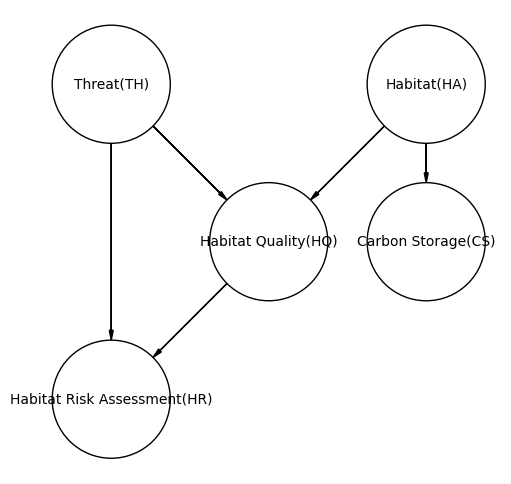

In [3]:
pgm_habitat=daft.PGM(grid_unit=4.0, node_unit=3)

pgm_habitat.add_node(daft.Node('HA', r"Habitat(HA)", 3, 3))
pgm_habitat.add_node(daft.Node('TH', r"Threat(TH)", 1, 3))
pgm_habitat.add_node(daft.Node('CS', r"Carbon Storage(CS)", 3, 2))
pgm_habitat.add_node(daft.Node('HQ', r"Habitat Quality(HQ)", 2, 2))
pgm_habitat.add_node(daft.Node('HR', r"Habitat Risk Assessment(HR)", 1, 1))

pgm_habitat.add_edge('TH','HQ')
pgm_habitat.add_edge('HA','HQ')
pgm_habitat.add_edge('HA','CS')
pgm_habitat.add_edge('TH','HR')
pgm_habitat.add_edge('HQ','HR')

pgm_habitat.render();

#### 2）因子分解

一般来讲，BN 中的每一个随机变量$X$都关联着一个 CPD，在已知其父节点每种可能状态的条件下，用来指明$X$状态的一个分布，记为$P(node \mid Par(node))$，式中，$Par(node)$为图中节点$node$的父节点，例如随机变量$HQ$依赖于$TH$和$HA$，其 CPD 表示为$P(HQ \mid TH,HA)$，对应着一个条件分布律（表）为变量`cpd_hq_sn`。对没有父节点的节点，例如$TH$和$HA$，其CPD以空集$Ø$为条件，实际上即为边缘分布$P(TH)$和$P(HA)$。对应各随机变量节点的 CPDs 图如下：

<img src="../imgs/3_5_b/3_5_b_01.jpg" height='auto' width=800 title="caDesign"> 

对于上述 BN（PGM）所有随机变量（属性、特征）的联合概率分布，考虑到随机变量之间的相互独立性，可以得到$P(TH,HA,HQ,CS,HR)=P(TH)P(HA)P(HQ \mid TH,HA)P(CS \mid HA)P(HR \mid TH,HQ)$，即对于 BN 的随机变量$\{X_1,X_2,\cdots,X_n\}$有联合概率分布$P\left(X_1, X_2, \ldots, X_n\right)=\prod_{i=1}^n P\left(X_i \mid \operatorname{Par}\left(X_i\right)\right)$，该公式为**贝叶斯网的链式法则**。可以表述为基于随机变量的独立性假设，PGM 分布$P$根据图$G$的因子分解（factorization），对应公式为$P\left(X_1, X_2, \ldots, X_n\right)=\prod_{i=1}^n P\left(X_i \mid \operatorname{Par}_G\left(X_i\right)\right)$。

* 定义参数：条件概率分布

使用`pgmpy`库的`TabularCPD`方法建立随机变量的 CPDs。

In [4]:
cpd_ha_sn=TabularCPD(variable='HA', variable_card=2, values=[[0.6], [0.4]], state_names={'HA': ['suitable', 'not suitable']})
cpd_th_sn=TabularCPD(variable='TH', variable_card=3, values=[[0.5], [0.3],[0.2]], state_names={'TH': ['strong', 'moderate','weak']})

cpd_cs_sn=TabularCPD(variable='CS', variable_card=3, 
                      values=[[0.7,0.3],
                              [0.2,0.3],
                              [0.1,0.4]],
                      evidence=['HA'],
                      evidence_card=[2],
                      state_names={'CS': ['rich', 'average','poor'],
                                   'HA':  ['suitable', 'not suitable']})

cpd_hq_sn=TabularCPD(variable='HQ', variable_card=2, 
                      values=[[0.2,0.4,0.9,0.3,0.3,0.4],
                              [0.8,0.6,0.1,0.7,0.7,0.6]],
                      evidence=['HA', 'TH'],
                      evidence_card=[2, 3],
                      state_names={'HQ': ['good', 'bad'],
                                   'HA': ['suitable', 'not suitable'],
                                   'TH': ['strong', 'moderate','weak']})
cpd_hr_sn=TabularCPD(variable='HR', variable_card=2,
                      values=[[0.9,0.6,0.6,0.5,0.4,0.1],
                              [0.1,0.4,0.4,0.5,0.6,0.9]],
                      evidence=['TH','HQ'],
                      evidence_card=[3,2],
                      state_names={'HR': ['high', 'low'],                                   
                                   'TH': ['strong', 'moderate','weak'],
                                   'HQ': ['good', 'bad']}) 


print(f'# Habitat\n{cpd_ha_sn}')
print(f'# Threat\n{cpd_th_sn}')
print(f'# Carbon Storage\n{cpd_cs_sn}')
print(f'# Habitat Quality\n{cpd_hq_sn}')
print(f'# Habitat Risk Assessment\n{cpd_hr_sn}')

# Habitat
+------------------+-----+
| HA(suitable)     | 0.6 |
+------------------+-----+
| HA(not suitable) | 0.4 |
+------------------+-----+
# Threat
+--------------+-----+
| TH(strong)   | 0.5 |
+--------------+-----+
| TH(moderate) | 0.3 |
+--------------+-----+
| TH(weak)     | 0.2 |
+--------------+-----+
# Carbon Storage
+-------------+--------------+------------------+
| HA          | HA(suitable) | HA(not suitable) |
+-------------+--------------+------------------+
| CS(rich)    | 0.7          | 0.3              |
+-------------+--------------+------------------+
| CS(average) | 0.2          | 0.3              |
+-------------+--------------+------------------+
| CS(poor)    | 0.1          | 0.4              |
+-------------+--------------+------------------+
# Habitat Quality
+----------+--------------+--------------+--------------+------------------+------------------+------------------+
| HA       | HA(suitable) | HA(suitable) | HA(suitable) | HA(not suitable) | HA(not s

* 链接图和条件概率分布

转化`daft`库构建的图为`pgmpy`库的形式，并将`pgmpy`库建立的 CPDs 链接到该图上，完成 BN（PGM）的构建。可以通过`check_mode`方法检验构建的 PGM 是否正确，如果提示随机变量的边缘分布不为1等情况，则需要对假设的概率数值进行调整，直至检查返回`True`，表明构建的 PGM 成立。

In [5]:
bn_habitat=usda_pgm.convert_pgm_to_pgmpy(pgm_habitat)
bn_habitat.add_cpds(cpd_ha_sn,cpd_th_sn,cpd_cs_sn,cpd_hq_sn,cpd_hr_sn)
bn_habitat.check_model()

True

建立 PGM 后可以读取计算相关信息，例如随机变量的 CPDs，状态基数等。

In [10]:
print(bn_habitat.get_cpds())
print(bn_habitat.get_cpds('HA'))
print(bn_habitat.get_cardinality('TH'))

[<TabularCPD representing P(HA:2) at 0x10bcceb5970>, <TabularCPD representing P(TH:3) at 0x10bf64e1a30>, <TabularCPD representing P(CS:3 | HA:2) at 0x10bcceb59a0>, <TabularCPD representing P(HQ:2 | HA:2, TH:3) at 0x10bf64e1d00>, <TabularCPD representing P(HR:2 | TH:3, HQ:2) at 0x10bcceb5a00>]
+------------------+-----+
| HA(suitable)     | 0.6 |
+------------------+-----+
| HA(not suitable) | 0.4 |
+------------------+-----+
3


#### 3）图中的独立性

依赖性（Dependencies）和独立性（independencies）是分布的两个主要性质，对理解分布的特征非常重要，并可从根本上降低推断的计算成本。

* D-分离（D-separation）

**直接连接（Direct connection）**：当任意图（网络结构）$G$的随机变量（节点）$X$和$Y$有边$X  \rightarrow  Y（E(G)=XY）$时，不论图中其它随机变量的证据（ evidence）如何，都可以构建$X$和$Y$相互关联的分布。

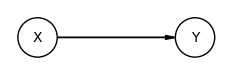

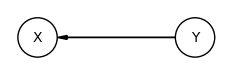

In [20]:
pgm_=daft.PGM()
pgm_.add_node(daft.Node('X', r"X", 1, 1))
pgm_.add_node(daft.Node('Y', r"Y", 3, 1))

pgm_xy=copy.deepcopy(pgm_)
pgm_xy.add_edge('X', 'Y')
pgm_xy.render();

#----------------------------------------------
pgm_yx=copy.deepcopy(pgm_)
pgm_yx.add_edge('Y', 'X')
pgm_yx.render();


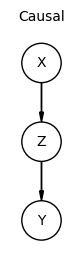

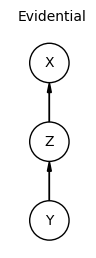

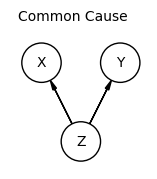

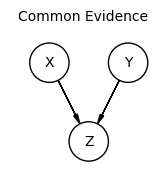

In [18]:
pgm_=daft.PGM()

pgm_.add_node(daft.Node('X', r"X", 1, 3))
pgm_.add_node(daft.Node('Z', r"Z", 1, 2))
pgm_.add_node(daft.Node('Y', r"Y", 1, 1))

#----------------------------------------------
pgm_causal=copy.deepcopy(pgm_)
pgm_causal.add_edge('X', 'Z')
pgm_causal.add_edge('Z', 'Y')
pgm_causal.add_text(0.7,3.5,label='Causal')
pgm_causal.render();

#----------------------------------------------
pgm_evidential=copy.deepcopy(pgm_)
pgm_evidential.add_edge('Y', 'Z')
pgm_evidential.add_edge('Z', 'X')
pgm_evidential.add_text(0.6,3.5,label='Evidential')
pgm_evidential.render();

#----------------------------------------------
pgm_=daft.PGM()

pgm_.add_node(daft.Node('X', r"X", 1, 2))
pgm_.add_node(daft.Node('Z', r"Z", 1.5, 1))
pgm_.add_node(daft.Node('Y', r"Y", 2, 2))

pgm_common_cause=copy.deepcopy(pgm_)
pgm_common_cause.add_edge('Z', 'X')
pgm_common_cause.add_edge('Z', 'Y')
pgm_common_cause.add_text(0.7,2.5,label='Common Cause')
pgm_common_cause.render();

#----------------------------------------------
pgm_common_evidence=copy.deepcopy(pgm_)
pgm_common_evidence.add_edge('X', 'Z')
pgm_common_evidence.add_edge('Y', 'Z')
pgm_common_evidence.add_text(0.6,2.5,label='Common Evidence')
pgm_common_evidence.render();

In [8]:
rvs_habitat=['HA','TH','CS','HQ','HR']
print(bn_habitat.local_independencies(rvs_habitat))

(HA ⟂ TH)
(TH ⟂ HA, CS)
(CS ⟂ TH, HR, HQ | HA)
(HQ ⟂ CS | TH, HA)
(HR ⟂ HA, CS | TH, HQ)


In [9]:
print(bn_habitat.get_independencies())

(TH ⟂ HA, CS)
(TH ⟂ CS | HA)
(TH ⟂ HA | CS)
(TH ⟂ CS | HA, HR)
(TH ⟂ CS | HA, HQ)
(TH ⟂ CS | HA, HR, HQ)
(HQ ⟂ CS | HA)
(HQ ⟂ CS | HA, HR)
(HQ ⟂ CS | HA, TH)
(HQ ⟂ CS | TH, HA, HR)
(HA ⟂ TH)
(HA ⟂ TH | CS)
(HA ⟂ HR | HQ, TH)
(HA ⟂ HR | HQ, TH, CS)
(HR ⟂ CS | HA)
(HR ⟂ CS | HA, TH)
(HR ⟂ CS | HA, HQ)
(HR ⟂ HA, CS | TH, HQ)
(HR ⟂ CS | HA, TH, HQ)
(HR ⟂ HA | TH, HQ, CS)
(CS ⟂ TH)
(CS ⟂ TH, HR, HQ | HA)
(CS ⟂ TH, HQ | HA, HR)
(CS ⟂ HQ, HR | HA, TH)
(CS ⟂ TH, HR | HA, HQ)
(CS ⟂ HR | TH, HQ)
(CS ⟂ HQ | TH, HA, HR)
(CS ⟂ TH | HA, HR, HQ)
(CS ⟂ HR | HA, TH, HQ)


### 3.5.2.2 推理

In [92]:
infer_habitat=VariableElimination(bn_habitat)

hq_dist=infer_habitat.query(['HQ'])
print(hq_dist)

+----------+-----------+
| HQ       |   phi(HQ) |
+==========+===========+
| HQ(good) |    0.3680 |
+----------+-----------+
| HQ(bad)  |    0.6320 |
+----------+-----------+


In [94]:
print(infer_habitat.query(['HQ'], evidence={'HA': 'suitable', 'TH': 'weak'}))

+----------+-----------+
| HQ       |   phi(HQ) |
+==========+===========+
| HQ(good) |    0.9000 |
+----------+-----------+
| HQ(bad)  |    0.1000 |
+----------+-----------+


In [99]:
print(infer_habitat.query(['HQ'], evidence={'HA': 'suitable', 'TH': 'weak','CS':'poor','HR':'high'}))

+----------+-----------+
| HQ       |   phi(HQ) |
+==========+===========+
| HQ(good) |    0.9730 |
+----------+-----------+
| HQ(bad)  |    0.0270 |
+----------+-----------+


In [95]:
infer_habitat.map_query(['HQ'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'HQ': 'bad'}

In [96]:
infer_habitat.map_query(['HQ'], evidence={'HA': 'suitable', 'TH': 'weak'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'HQ': 'good'}

In [97]:
infer_habitat.map_query(['HQ'], evidence={'HA': 'suitable', 'TH': 'weak','CS':'poor','HR':'high'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'HQ': 'good'}